# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
pip install pyspark

In [2]:
# install openjdk-8-jdk-headless -qq    

In [3]:
# import libraries
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [4]:

# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1640066798937'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '44807'),
 ('spark.app.startTime', '1640066795135'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'd1440250f3bb'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

#### load in the dataset

In [6]:
# !unzip "/content/mini_sparkify_event_data.zip" -d "/content/"

In [7]:
df = spark.read.json("mini_sparkify_event_data.json")

In [8]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# print 5 row of dataframe
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [10]:
# get the count of the dataset before we do any cleaning - this is 286500 and show some rows od dataframe
# df.count()
row_count = df.count()
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))
df.describe(df.columns[:6]).show()
df.describe(df.columns[6:13]).show()
df.describe(df.columns[13:]).show()

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18
+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201141042|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+

+-------+------------------+------+-----------------+------+-------+--------------------+-----------------+
|summary|            length| level|

####  Cleaning the Data

In [11]:
# drop rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [12]:
#Remove records with empty userId
df = df.filter(df['userId'] != '')

In [13]:
print("The number of rows in the dataframe is {}".format(df.count())) #before datacount 286500 now 278154
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 278154
The number of columns in the dataframe is 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


In [15]:
# clearly represent registration and timestamp by creating new columns
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_registration', new_ts('registration'))
df = df.withColumn('updated_ts', new_ts('ts'))

In [16]:
# add a new column "downgrade_value" to mark Submit Downgrade
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_value", downgrade_value("page"))

# label users who have downgraded
dg_window = Window.partitionBy('UserId')
df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

# add a new column "churn_value" to mark cancellation event
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

# label users who have churned
churn_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("user_churn", sum('churn_value').over(churn_window))

Text(0.5, 0, 'Subscription status')

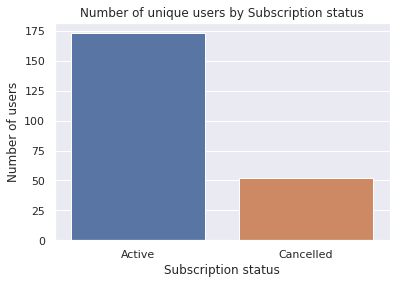

In [17]:
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId']).groupby(['user_churn']).count().sort("user_churn").toPandas()
sns.barplot(data =df_ch_pd, x = 'user_churn',y = 'count')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title('Number of unique users by Subscription status')
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5, 0, 'Subscription status')

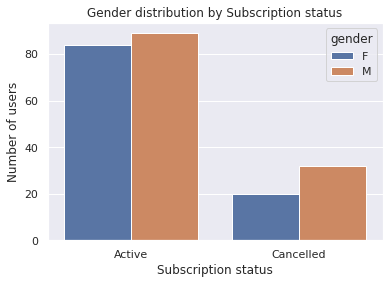

In [18]:
# Plotting a bar plot to show gender distribution by Subscription status
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')
churn_d = ['Active', 'Cancelled']
y_pos = np.arange(len(churn_d))
plt.xticks(y_pos,churn_d)
plt.title("Gender distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5, 0, 'Subscription status')

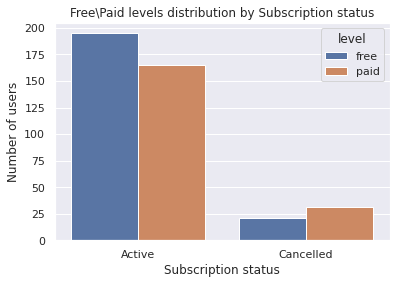

In [19]:
# Plotting a bar plot to show level distribution by Subscription status
plt.grid(True)
level_df = df.drop_duplicates(['userId','churn_value', 'level']).groupby(['churn_value', 'level']).count().sort("churn_value").toPandas()
sns.barplot(x = 'churn_value', y = 'count', data = level_df, hue = 'level')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title("Free\Paid levels distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5, 0, '% of envents')

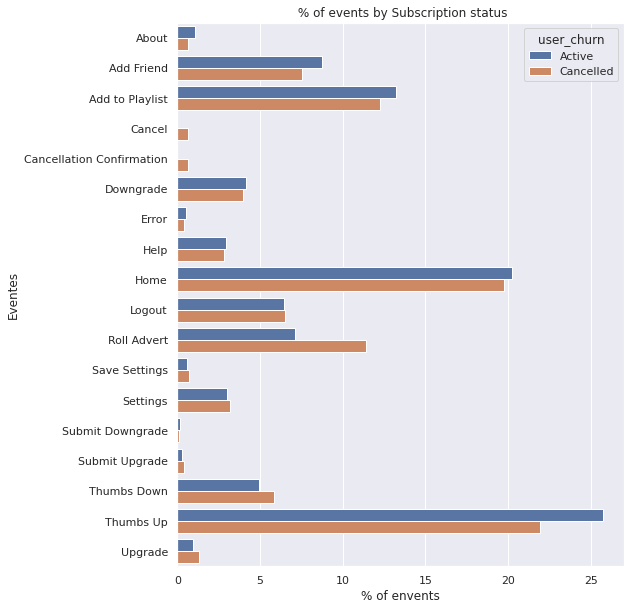

In [20]:
page_df = df.groupby(['page','user_churn']).count().toPandas()
page_df = page_df[page_df['page'] != 'NextSong']
page_df = ((page_df.groupby(['page','user_churn']).sum()/page_df.groupby(['user_churn']).sum())*100).reset_index()
page_df['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
plt.figure(figsize=(8,10))
plt.grid(True)
sns.barplot(y = 'page', x = 'count', data = page_df, hue = 'user_churn')
plt.title(" % of events by Subscription status")
sns.set_hls_values
plt.ylabel('Eventes')
plt.xlabel('% of envents')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
# Feature 1 : Total number of  songs listened
feat_1 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')

In [22]:
# Feature 2 : Total time spent 
feat_2 = df.select('userID','length').groupBy('userID').agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listen_time')

In [23]:
# Feature 3 : Number of thumbs-up, Feature 4 : thumbs-down
feat_3 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_up')
feat_4 = df .select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_down')


In [24]:
# Feature 5 : Number of adds to playlist
feat_5 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')


In [25]:
# Feature 6 : Number of lifetime
feat_6 = df.select('userID','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userID').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lt')


In [26]:
# Feature 7 : Total number of friends
feat_7 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')

In [27]:
# Feature 8 : Gender of the user
feat_8 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

In [28]:
# Feature 9: Number of help AND  Feature 10 : Number of rolladvert
feat_9 = df.select('userID','page').where(df.page == 'Help').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'help') 
feat_10 = df.select('userID','page').where(df.page == 'Roll Advert').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'rolladvert')


In [29]:
# Feature 11 : Total number of songs listened per session
feat_11  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

In [30]:
# Feature 12 : Total number of artists the user has listened to
feat_12 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")

In [31]:
# setting the churn label for our model
target = df.select('userId', col('user_churn').alias('label')).dropDuplicates()

In [32]:
# Combining all features with the target churn label
final_data  = feat_1.join(feat_2,'userID','outer') \
    .join(feat_3,'userID','outer') \
    .join(feat_4,'userID','outer') \
    .join(feat_5,'userID','outer') \
    .join(feat_6,'userID','outer') \
    .join(feat_7,'userID','outer') \
    .join(feat_8,'userID','outer') \
    .join(feat_9,'userID','outer') \
    .join(feat_10,'userID','outer') \
    .join(feat_11,'userID','outer') \
    .join(feat_12,'userID','outer') \
    .join(target,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [33]:
final_data.show(5)

+---------+------------------+------------+--------------+---------------+-----------+-----------+------+----+----------+------------------+-----------------+-----+
|tot_songs|       listen_time|num_thumb_up|num_thumb_down|add_to_playlist|         lt|tot_friends|gender|help|rolladvert|  avg_played_songs|tot_artist_played|label|
+---------+------------------+------------+--------------+---------------+-----------+-----------+------+----+----------+------------------+-----------------+-----+
|      795|166866.37251000002|          37|             4|              9| 4472293000|         12|     1|   1|         1|112.16666666666667|              565|    0|
|     3214| 672877.8565899999|         148|            27|             61| 5605094000|         49|     1|  18|        25| 78.88235294117646|             1705|    0|
|      187|35073.742150000005|           8|             2|              3| 3870739000|          2|     0|   1|        14|             33.25|              125|    1|
|      218

In [34]:
incol = ['tot_songs',
 'listen_time',
 'num_thumb_up',
 'num_thumb_down',
 'add_to_playlist',
 'lt',
 'tot_friends',
 'gender',
 'help',
 'rolladvert',
 'avg_played_songs',
 'tot_artist_played']
assembler = VectorAssembler(inputCols=incol, outputCol="NumFeatures")
final_data = assembler.transform(final_data)

In [35]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler2.fit(final_data)
final_data = scalerModel.transform(final_data)

In [36]:
final_data.take(2)

[Row(tot_songs=795, listen_time=166866.37251000002, num_thumb_up=37, num_thumb_down=4, add_to_playlist=9, lt=4472293000, tot_friends=12, gender=1, help=1, rolladvert=1, avg_played_songs=112.16666666666667, tot_artist_played=565, label=0, NumFeatures=DenseVector([795.0, 166866.3725, 37.0, 4.0, 9.0, 4472293000.0, 12.0, 1.0, 1.0, 1.0, 112.1667, 565.0]), features=DenseVector([0.598, 0.6059, 0.5651, 0.3059, 0.2751, 1.3744, 0.583, 2.0013, 0.1381, 0.0464, 2.6321, 0.9355])),
 Row(tot_songs=3214, listen_time=672877.8565899999, num_thumb_up=148, num_thumb_down=27, add_to_playlist=61, lt=5605094000, tot_friends=49, gender=1, help=18, rolladvert=25, avg_played_songs=78.88235294117646, tot_artist_played=1705, label=0, NumFeatures=DenseVector([3214.0, 672877.8566, 148.0, 27.0, 61.0, 5605094000.0, 49.0, 1.0, 18.0, 25.0, 78.8824, 1705.0]), features=DenseVector([2.4174, 2.4433, 2.2603, 2.0646, 1.8645, 1.7226, 2.3808, 2.0013, 2.4853, 1.1601, 1.851, 2.8231]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [37]:
final_data2 = final_data.select('label','features')

In [38]:
train,validation = final_data2.randomSplit([0.8, 0.2], seed=50)

In [39]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam =0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10,  regParam = 0.01)

In [40]:
#Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.7261855843482503, 0.7090033708379673, 0.6651118892910759]

In [41]:
# Support Vector Machine 
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q2 = crossval.fit(train)
cvModel_q2.avgMetrics

[0.6981530583500168, 0.6651118892910759, 0.6679271034270446]

In [42]:
# Gradient boosted tree
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q3 = crossval.fit(train)
cvModel_q3.avgMetrics

[0.7265690975196695, 0.6963802702490324]

In [43]:
gbt_tuned = GBTClassifier(maxDepth=5,maxIter=10,seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.775


In [45]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.754616048317515


In [46]:
gbt_model.featureImportances

SparseVector(12, {0: 0.1112, 1: 0.0288, 2: 0.0634, 3: 0.1121, 4: 0.095, 5: 0.2105, 6: 0.0856, 7: 0.0171, 8: 0.0308, 9: 0.108, 10: 0.1202, 11: 0.0174})

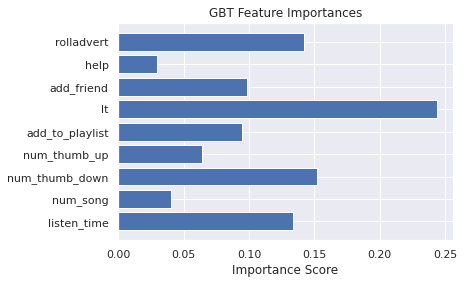

In [47]:
importances  = [ 0.134,0.0408,0.1519,0.0639,0.0946,0.2436,0.0988,0.0301,0.1421]
feature = ["listen_time", "num_song", "num_thumb_down", \
          'num_thumb_up','add_to_playlist','lt','add_friend','help','rolladvert']
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=300)


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.